In [27]:
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import nn, optim
from torch.autograd import Variable
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

In [45]:
def generate_shift_one_dim_dataset(n, p, q, seed):
    rng = np.random.RandomState(seed)
    
    us1 = rng.binomial(n=1, p=p, size=int(n * q))
    xs1 = rng.uniform(0.0, 10.0, size=int(n * q))
    noise1 = rng.normal(0.0, 50.0, size=int(n * q))
    ys1 = xs1 * xs1 * xs1 + 1 * xs1 * xs1 * xs1 * us1 + noise1
    
    us2 = rng.binomial(n=1, p=p, size=int(n * (1 - q)))
    xs2 = rng.uniform(0.0, 1.0, size=int(n * (1 - q)))
    noise2 = rng.normal(0.0, 50.0, size=int(n * (1 - q)))
    ys2 = xs2 * xs2 * xs2 + 1 * xs2 * xs2 * xs2 * us2 + noise2
    
    xs = np.concatenate((xs1, xs2))
    ys = np.concatenate((ys1, ys2))
    return xs.reshape(-1, 1), ys.reshape(-1, 1)

In [46]:
def standardize(data):
    mu = data.mean(axis=0, keepdims=1)
    scale = data.std(axis=0, keepdims=1)
    # scale[scale < 1e-10] = 1.0
    data = (data - mu) / scale
    return data, mu, scale

In [47]:
def get_dataloaders(
    X_unstandardized, y_unstandardized, X_train, y_train, X_val, y_val, X_tests, y_tests, seed,
):
    X_train, x_train_mu, x_train_scale = standardize(X_train)
    y_train, y_train_mu, y_train_scale = standardize(y_train)
    
    X_val = (X_val - x_train_mu) / x_train_scale
    y_val = (y_val - y_train_mu) / y_train_scale
    
    for i in range(len(y_tests)):
        y_tests[i] = (y_tests[i] - y_train_mu) / y_train_scale
        X_tests[i] = (X_tests[i] - x_train_mu) / x_train_scale

    x_train_mu = x_train_mu.item()
    x_train_scale = x_train_scale.item()
    y_train_mu = y_train_mu.item()
    y_train_scale = y_train_scale.item()
    
    train = TensorDataset(
        torch.Tensor(X_train),
        torch.Tensor(y_train),
    )
    train_loader = DataLoader(
        train, batch_size=int(X_train.shape[0] * 0.25), shuffle=True
    )

    val = TensorDataset(
        torch.Tensor(X_val),
        torch.Tensor(y_val),
    )
    val_loader = DataLoader(val, batch_size=len(val), shuffle=False)

    test_loaders = []
    for i in range(len(y_tests)):
        test = TensorDataset(
            torch.Tensor(X_tests[i]),
            torch.Tensor(y_tests[i]),
        )
        test_loader = DataLoader(test, batch_size=len(test), shuffle=False)
        test_loaders.append(test_loader)

    return (
        X_unstandardized,
        y_unstandardized,
        train_loader,
        val_loader,
        test_loaders,
        X_train[0].shape[0],
        x_train_mu,
        x_train_scale,
        y_train_mu,
        y_train_scale,
    )

In [48]:
def get_shift_one_dim_dataloaders(
    n_train, seed, p_train, q_train, p_tests, q_tests
):
    X_train = []
    y_train = []
    
    X_val, y_val = generate_shift_one_dim_dataset(
        n=int(n_train * 0.2), p=p_train, q=q_train, seed=seed
    )
    
    X_tests = []
    y_tests = []
    X_unstandardized = []
    y_unstandardized = []
    for q_test in q_tests:
        for p_test in p_tests:
            X_test, y_test = generate_shift_one_dim_dataset(
                n=10000, p=p_test, q=q_test, seed=seed + 1
            )
            X_tests.append(X_test)
            y_tests.append(y_test)
            X_unstandardized.append(X_test)
            y_unstandardized.append(y_test)
            if (q_test == 0.5 and p_test == 0.5):
                X_train = X_test
                y_train = y_test
    
    return (
        get_dataloaders(X_unstandardized, y_unstandardized, X_train, y_train, X_val, y_val, X_tests, y_tests, seed)
    )

In [49]:
p_tests = [0.5, 0.9]
q_tests = [1, 0.5, 0.1]
X_unstandardized, y_unstandardized, train_loader, val_loader, test_loaders, X_train_shape, x_train_mu, x_train_scale, y_train_mu, y_train_scale = get_shift_one_dim_dataloaders(n_train=7000, seed=42, p_train=0.5, q_train=0.5, p_tests=p_tests, q_tests=q_tests)

In [50]:
l_rate = 0.01 #appropriate learning rate? 1e-2 or 1e-3
mse_loss = nn.MSELoss(reduction = 'mean')

In [51]:
class Regression(pl.LightningModule):
    def __init__(self):
        super(Regression, self).__init__()
        self.fc1 = nn.Linear(1, 1) #how many layers and what size?
        self.validation_losses = []
        self.test_losses = []

    def forward(self, x):
        x = self.fc1(x)  # No activation function?
        return x
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=l_rate) #adam optimizer
    
    def training_step(self, batch, batch_idx):
        breakpoint()
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        logs = {'loss': loss}
        print(loss)
        return {'loss': loss, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        breakpoint()
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        self.log('val_loss', loss) #why do i get error message w/o this line
        self.validation_losses.append(loss.item())
        print(loss)
        return loss

    def on_validation_epoch_end(self):
        breakpoint()
        avg_loss = sum(self.validation_losses) / len(self.validation_losses)
        tensorboard_logs = {'val_loss': avg_loss}
        self.log('avg_val_loss', avg_loss, on_epoch=True, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        breakpoint()
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        predictions.append(logits)
        self.test_losses.append(loss.item())
        return loss
    
    def on_test_epoch_end(self):
        breakpoint()
        avg_loss = sum(self.test_losses) / len(self.test_losses)
        logs = {'test_loss': avg_loss}      
        avg_losses.append(avg_loss)
        return avg_loss

In [52]:
model = Regression()
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='checkpoints/')
trainer = Trainer(max_epochs = 100, callbacks=[checkpoint_callback]) #epochs
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader) #comment out dataloader functions and make loop and pass dataloaders

/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/groups/swager/mliu1785/miniconda3/envs/researc ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 2     
----

Sanity Checking: 0it [00:00, ?it/s]

tensor(0.4409)


/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUs

Training: 0it [00:00, ?it/s]

tensor(0.4111, grad_fn=<MseLossBackward0>)
tensor(0.4007, grad_fn=<MseLossBackward0>)
tensor(0.3681, grad_fn=<MseLossBackward0>)
tensor(0.4404, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.4030)
tensor(0.3663, grad_fn=<MseLossBackward0>)
tensor(0.3594, grad_fn=<MseLossBackward0>)
tensor(0.3506, grad_fn=<MseLossBackward0>)
tensor(0.4078, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.3720)
tensor(0.3476, grad_fn=<MseLossBackward0>)
tensor(0.3019, grad_fn=<MseLossBackward0>)
tensor(0.3578, grad_fn=<MseLossBackward0>)
tensor(0.3689, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.3478)
tensor(0.3107, grad_fn=<MseLossBackward0>)
tensor(0.3361, grad_fn=<MseLossBackward0>)
tensor(0.3255, grad_fn=<MseLossBackward0>)
tensor(0.3237, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.3298)
tensor(0.3104, grad_fn=<MseLossBackward0>)
tensor(0.2811, grad_fn=<MseLossBackward0>)
tensor(0.2912, grad_fn=<MseLossBackward0>)
tensor(0.3542, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.3171)
tensor(0.3019, grad_fn=<MseLossBackward0>)
tensor(0.3005, grad_fn=<MseLossBackward0>)
tensor(0.3027, grad_fn=<MseLossBackward0>)
tensor(0.2937, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.3082)
tensor(0.3100, grad_fn=<MseLossBackward0>)
tensor(0.2823, grad_fn=<MseLossBackward0>)
tensor(0.2872, grad_fn=<MseLossBackward0>)
tensor(0.2917, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.3022)
tensor(0.2852, grad_fn=<MseLossBackward0>)
tensor(0.2994, grad_fn=<MseLossBackward0>)
tensor(0.2704, grad_fn=<MseLossBackward0>)
tensor(0.2972, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2981)
tensor(0.2477, grad_fn=<MseLossBackward0>)
tensor(0.2970, grad_fn=<MseLossBackward0>)
tensor(0.2920, grad_fn=<MseLossBackward0>)
tensor(0.3022, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2956)
tensor(0.2848, grad_fn=<MseLossBackward0>)
tensor(0.2895, grad_fn=<MseLossBackward0>)
tensor(0.2915, grad_fn=<MseLossBackward0>)
tensor(0.2663, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2942)
tensor(0.2670, grad_fn=<MseLossBackward0>)
tensor(0.2880, grad_fn=<MseLossBackward0>)
tensor(0.2910, grad_fn=<MseLossBackward0>)
tensor(0.2821, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2677, grad_fn=<MseLossBackward0>)
tensor(0.2819, grad_fn=<MseLossBackward0>)
tensor(0.2955, grad_fn=<MseLossBackward0>)
tensor(0.2817, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.3085, grad_fn=<MseLossBackward0>)
tensor(0.2807, grad_fn=<MseLossBackward0>)
tensor(0.2723, grad_fn=<MseLossBackward0>)
tensor(0.2661, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2939)
tensor(0.2784, grad_fn=<MseLossBackward0>)
tensor(0.2997, grad_fn=<MseLossBackward0>)
tensor(0.2521, grad_fn=<MseLossBackward0>)
tensor(0.2976, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2940)
tensor(0.2880, grad_fn=<MseLossBackward0>)
tensor(0.3030, grad_fn=<MseLossBackward0>)
tensor(0.2633, grad_fn=<MseLossBackward0>)
tensor(0.2738, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2939)
tensor(0.2823, grad_fn=<MseLossBackward0>)
tensor(0.2898, grad_fn=<MseLossBackward0>)
tensor(0.2763, grad_fn=<MseLossBackward0>)
tensor(0.2797, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2898, grad_fn=<MseLossBackward0>)
tensor(0.2812, grad_fn=<MseLossBackward0>)
tensor(0.2823, grad_fn=<MseLossBackward0>)
tensor(0.2745, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.3125, grad_fn=<MseLossBackward0>)
tensor(0.2624, grad_fn=<MseLossBackward0>)
tensor(0.2739, grad_fn=<MseLossBackward0>)
tensor(0.2787, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2936)
tensor(0.2692, grad_fn=<MseLossBackward0>)
tensor(0.2765, grad_fn=<MseLossBackward0>)
tensor(0.2905, grad_fn=<MseLossBackward0>)
tensor(0.2913, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2936)
tensor(0.2855, grad_fn=<MseLossBackward0>)
tensor(0.2635, grad_fn=<MseLossBackward0>)
tensor(0.2931, grad_fn=<MseLossBackward0>)
tensor(0.2850, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2936)
tensor(0.2985, grad_fn=<MseLossBackward0>)
tensor(0.2730, grad_fn=<MseLossBackward0>)
tensor(0.2744, grad_fn=<MseLossBackward0>)
tensor(0.2812, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2594, grad_fn=<MseLossBackward0>)
tensor(0.2916, grad_fn=<MseLossBackward0>)
tensor(0.2885, grad_fn=<MseLossBackward0>)
tensor(0.2876, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2832, grad_fn=<MseLossBackward0>)
tensor(0.2591, grad_fn=<MseLossBackward0>)
tensor(0.2900, grad_fn=<MseLossBackward0>)
tensor(0.2948, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2954, grad_fn=<MseLossBackward0>)
tensor(0.2704, grad_fn=<MseLossBackward0>)
tensor(0.2627, grad_fn=<MseLossBackward0>)
tensor(0.2985, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2729, grad_fn=<MseLossBackward0>)
tensor(0.2892, grad_fn=<MseLossBackward0>)
tensor(0.2667, grad_fn=<MseLossBackward0>)
tensor(0.2982, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2920, grad_fn=<MseLossBackward0>)
tensor(0.2753, grad_fn=<MseLossBackward0>)
tensor(0.2689, grad_fn=<MseLossBackward0>)
tensor(0.2908, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.3003, grad_fn=<MseLossBackward0>)
tensor(0.2803, grad_fn=<MseLossBackward0>)
tensor(0.2831, grad_fn=<MseLossBackward0>)
tensor(0.2633, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2880, grad_fn=<MseLossBackward0>)
tensor(0.2695, grad_fn=<MseLossBackward0>)
tensor(0.2884, grad_fn=<MseLossBackward0>)
tensor(0.2812, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2951, grad_fn=<MseLossBackward0>)
tensor(0.2714, grad_fn=<MseLossBackward0>)
tensor(0.2743, grad_fn=<MseLossBackward0>)
tensor(0.2862, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2728, grad_fn=<MseLossBackward0>)
tensor(0.2558, grad_fn=<MseLossBackward0>)
tensor(0.3033, grad_fn=<MseLossBackward0>)
tensor(0.2952, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2491, grad_fn=<MseLossBackward0>)
tensor(0.2927, grad_fn=<MseLossBackward0>)
tensor(0.2884, grad_fn=<MseLossBackward0>)
tensor(0.2969, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2995, grad_fn=<MseLossBackward0>)
tensor(0.2629, grad_fn=<MseLossBackward0>)
tensor(0.2707, grad_fn=<MseLossBackward0>)
tensor(0.2939, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.3015, grad_fn=<MseLossBackward0>)
tensor(0.2692, grad_fn=<MseLossBackward0>)
tensor(0.2890, grad_fn=<MseLossBackward0>)
tensor(0.2673, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2641, grad_fn=<MseLossBackward0>)
tensor(0.2908, grad_fn=<MseLossBackward0>)
tensor(0.2971, grad_fn=<MseLossBackward0>)
tensor(0.2749, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2845, grad_fn=<MseLossBackward0>)
tensor(0.2812, grad_fn=<MseLossBackward0>)
tensor(0.2801, grad_fn=<MseLossBackward0>)
tensor(0.2813, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2777, grad_fn=<MseLossBackward0>)
tensor(0.2583, grad_fn=<MseLossBackward0>)
tensor(0.2887, grad_fn=<MseLossBackward0>)
tensor(0.3023, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2670, grad_fn=<MseLossBackward0>)
tensor(0.3161, grad_fn=<MseLossBackward0>)
tensor(0.2936, grad_fn=<MseLossBackward0>)
tensor(0.2504, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2667, grad_fn=<MseLossBackward0>)
tensor(0.2750, grad_fn=<MseLossBackward0>)
tensor(0.3009, grad_fn=<MseLossBackward0>)
tensor(0.2846, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.3007, grad_fn=<MseLossBackward0>)
tensor(0.2986, grad_fn=<MseLossBackward0>)
tensor(0.2757, grad_fn=<MseLossBackward0>)
tensor(0.2521, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2915, grad_fn=<MseLossBackward0>)
tensor(0.2693, grad_fn=<MseLossBackward0>)
tensor(0.2869, grad_fn=<MseLossBackward0>)
tensor(0.2793, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2961, grad_fn=<MseLossBackward0>)
tensor(0.2750, grad_fn=<MseLossBackward0>)
tensor(0.2664, grad_fn=<MseLossBackward0>)
tensor(0.2895, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2743, grad_fn=<MseLossBackward0>)
tensor(0.2864, grad_fn=<MseLossBackward0>)
tensor(0.2546, grad_fn=<MseLossBackward0>)
tensor(0.3118, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.3044, grad_fn=<MseLossBackward0>)
tensor(0.2609, grad_fn=<MseLossBackward0>)
tensor(0.2748, grad_fn=<MseLossBackward0>)
tensor(0.2870, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2941, grad_fn=<MseLossBackward0>)
tensor(0.2588, grad_fn=<MseLossBackward0>)
tensor(0.2813, grad_fn=<MseLossBackward0>)
tensor(0.2928, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2698, grad_fn=<MseLossBackward0>)
tensor(0.2634, grad_fn=<MseLossBackward0>)
tensor(0.2848, grad_fn=<MseLossBackward0>)
tensor(0.3091, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2984, grad_fn=<MseLossBackward0>)
tensor(0.2875, grad_fn=<MseLossBackward0>)
tensor(0.2832, grad_fn=<MseLossBackward0>)
tensor(0.2579, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2859, grad_fn=<MseLossBackward0>)
tensor(0.2736, grad_fn=<MseLossBackward0>)
tensor(0.2904, grad_fn=<MseLossBackward0>)
tensor(0.2771, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2958, grad_fn=<MseLossBackward0>)
tensor(0.2774, grad_fn=<MseLossBackward0>)
tensor(0.2687, grad_fn=<MseLossBackward0>)
tensor(0.2852, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2957, grad_fn=<MseLossBackward0>)
tensor(0.2932, grad_fn=<MseLossBackward0>)
tensor(0.2827, grad_fn=<MseLossBackward0>)
tensor(0.2556, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2953, grad_fn=<MseLossBackward0>)
tensor(0.3028, grad_fn=<MseLossBackward0>)
tensor(0.2416, grad_fn=<MseLossBackward0>)
tensor(0.2874, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2792, grad_fn=<MseLossBackward0>)
tensor(0.2864, grad_fn=<MseLossBackward0>)
tensor(0.2914, grad_fn=<MseLossBackward0>)
tensor(0.2700, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2847, grad_fn=<MseLossBackward0>)
tensor(0.2862, grad_fn=<MseLossBackward0>)
tensor(0.2720, grad_fn=<MseLossBackward0>)
tensor(0.2842, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2988, grad_fn=<MseLossBackward0>)
tensor(0.2965, grad_fn=<MseLossBackward0>)
tensor(0.2757, grad_fn=<MseLossBackward0>)
tensor(0.2562, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2774, grad_fn=<MseLossBackward0>)
tensor(0.2882, grad_fn=<MseLossBackward0>)
tensor(0.2694, grad_fn=<MseLossBackward0>)
tensor(0.2921, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2974, grad_fn=<MseLossBackward0>)
tensor(0.2860, grad_fn=<MseLossBackward0>)
tensor(0.2584, grad_fn=<MseLossBackward0>)
tensor(0.2853, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2701, grad_fn=<MseLossBackward0>)
tensor(0.2791, grad_fn=<MseLossBackward0>)
tensor(0.2800, grad_fn=<MseLossBackward0>)
tensor(0.2978, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2877, grad_fn=<MseLossBackward0>)
tensor(0.2820, grad_fn=<MseLossBackward0>)
tensor(0.2734, grad_fn=<MseLossBackward0>)
tensor(0.2840, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2785, grad_fn=<MseLossBackward0>)
tensor(0.3039, grad_fn=<MseLossBackward0>)
tensor(0.2609, grad_fn=<MseLossBackward0>)
tensor(0.2837, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2700, grad_fn=<MseLossBackward0>)
tensor(0.2846, grad_fn=<MseLossBackward0>)
tensor(0.2880, grad_fn=<MseLossBackward0>)
tensor(0.2844, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2726, grad_fn=<MseLossBackward0>)
tensor(0.2816, grad_fn=<MseLossBackward0>)
tensor(0.2826, grad_fn=<MseLossBackward0>)
tensor(0.2903, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2659, grad_fn=<MseLossBackward0>)
tensor(0.2624, grad_fn=<MseLossBackward0>)
tensor(0.3024, grad_fn=<MseLossBackward0>)
tensor(0.2964, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2719, grad_fn=<MseLossBackward0>)
tensor(0.2855, grad_fn=<MseLossBackward0>)
tensor(0.2841, grad_fn=<MseLossBackward0>)
tensor(0.2855, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.3036, grad_fn=<MseLossBackward0>)
tensor(0.2642, grad_fn=<MseLossBackward0>)
tensor(0.2524, grad_fn=<MseLossBackward0>)
tensor(0.3069, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2820, grad_fn=<MseLossBackward0>)
tensor(0.3001, grad_fn=<MseLossBackward0>)
tensor(0.2706, grad_fn=<MseLossBackward0>)
tensor(0.2744, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2798, grad_fn=<MseLossBackward0>)
tensor(0.2759, grad_fn=<MseLossBackward0>)
tensor(0.2863, grad_fn=<MseLossBackward0>)
tensor(0.2851, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.3112, grad_fn=<MseLossBackward0>)
tensor(0.2923, grad_fn=<MseLossBackward0>)
tensor(0.2516, grad_fn=<MseLossBackward0>)
tensor(0.2719, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2891, grad_fn=<MseLossBackward0>)
tensor(0.2985, grad_fn=<MseLossBackward0>)
tensor(0.2686, grad_fn=<MseLossBackward0>)
tensor(0.2708, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2680, grad_fn=<MseLossBackward0>)
tensor(0.2987, grad_fn=<MseLossBackward0>)
tensor(0.2709, grad_fn=<MseLossBackward0>)
tensor(0.2895, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2714, grad_fn=<MseLossBackward0>)
tensor(0.2766, grad_fn=<MseLossBackward0>)
tensor(0.2999, grad_fn=<MseLossBackward0>)
tensor(0.2791, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2905, grad_fn=<MseLossBackward0>)
tensor(0.2740, grad_fn=<MseLossBackward0>)
tensor(0.3052, grad_fn=<MseLossBackward0>)
tensor(0.2574, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2826, grad_fn=<MseLossBackward0>)
tensor(0.2757, grad_fn=<MseLossBackward0>)
tensor(0.2918, grad_fn=<MseLossBackward0>)
tensor(0.2771, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.3079, grad_fn=<MseLossBackward0>)
tensor(0.2601, grad_fn=<MseLossBackward0>)
tensor(0.2864, grad_fn=<MseLossBackward0>)
tensor(0.2727, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2980, grad_fn=<MseLossBackward0>)
tensor(0.2738, grad_fn=<MseLossBackward0>)
tensor(0.2696, grad_fn=<MseLossBackward0>)
tensor(0.2856, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2907, grad_fn=<MseLossBackward0>)
tensor(0.2997, grad_fn=<MseLossBackward0>)
tensor(0.2725, grad_fn=<MseLossBackward0>)
tensor(0.2642, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2871, grad_fn=<MseLossBackward0>)
tensor(0.2972, grad_fn=<MseLossBackward0>)
tensor(0.2768, grad_fn=<MseLossBackward0>)
tensor(0.2660, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2867, grad_fn=<MseLossBackward0>)
tensor(0.2739, grad_fn=<MseLossBackward0>)
tensor(0.3000, grad_fn=<MseLossBackward0>)
tensor(0.2664, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2700, grad_fn=<MseLossBackward0>)
tensor(0.2745, grad_fn=<MseLossBackward0>)
tensor(0.2850, grad_fn=<MseLossBackward0>)
tensor(0.2976, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2767, grad_fn=<MseLossBackward0>)
tensor(0.2809, grad_fn=<MseLossBackward0>)
tensor(0.3046, grad_fn=<MseLossBackward0>)
tensor(0.2649, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2830, grad_fn=<MseLossBackward0>)
tensor(0.2796, grad_fn=<MseLossBackward0>)
tensor(0.2966, grad_fn=<MseLossBackward0>)
tensor(0.2678, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2768, grad_fn=<MseLossBackward0>)
tensor(0.2975, grad_fn=<MseLossBackward0>)
tensor(0.2846, grad_fn=<MseLossBackward0>)
tensor(0.2681, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2612, grad_fn=<MseLossBackward0>)
tensor(0.2736, grad_fn=<MseLossBackward0>)
tensor(0.3094, grad_fn=<MseLossBackward0>)
tensor(0.2827, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2657, grad_fn=<MseLossBackward0>)
tensor(0.2803, grad_fn=<MseLossBackward0>)
tensor(0.3017, grad_fn=<MseLossBackward0>)
tensor(0.2794, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.3015, grad_fn=<MseLossBackward0>)
tensor(0.2779, grad_fn=<MseLossBackward0>)
tensor(0.2987, grad_fn=<MseLossBackward0>)
tensor(0.2490, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2720, grad_fn=<MseLossBackward0>)
tensor(0.2886, grad_fn=<MseLossBackward0>)
tensor(0.2709, grad_fn=<MseLossBackward0>)
tensor(0.2955, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2959, grad_fn=<MseLossBackward0>)
tensor(0.2921, grad_fn=<MseLossBackward0>)
tensor(0.2921, grad_fn=<MseLossBackward0>)
tensor(0.2471, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.3006, grad_fn=<MseLossBackward0>)
tensor(0.2834, grad_fn=<MseLossBackward0>)
tensor(0.2732, grad_fn=<MseLossBackward0>)
tensor(0.2699, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2931, grad_fn=<MseLossBackward0>)
tensor(0.2850, grad_fn=<MseLossBackward0>)
tensor(0.2588, grad_fn=<MseLossBackward0>)
tensor(0.2902, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2785, grad_fn=<MseLossBackward0>)
tensor(0.2874, grad_fn=<MseLossBackward0>)
tensor(0.3022, grad_fn=<MseLossBackward0>)
tensor(0.2589, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2927, grad_fn=<MseLossBackward0>)
tensor(0.2666, grad_fn=<MseLossBackward0>)
tensor(0.2790, grad_fn=<MseLossBackward0>)
tensor(0.2888, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2804, grad_fn=<MseLossBackward0>)
tensor(0.2863, grad_fn=<MseLossBackward0>)
tensor(0.2729, grad_fn=<MseLossBackward0>)
tensor(0.2874, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2790, grad_fn=<MseLossBackward0>)
tensor(0.2723, grad_fn=<MseLossBackward0>)
tensor(0.2785, grad_fn=<MseLossBackward0>)
tensor(0.2974, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2887, grad_fn=<MseLossBackward0>)
tensor(0.2899, grad_fn=<MseLossBackward0>)
tensor(0.2832, grad_fn=<MseLossBackward0>)
tensor(0.2653, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2875, grad_fn=<MseLossBackward0>)
tensor(0.2665, grad_fn=<MseLossBackward0>)
tensor(0.2880, grad_fn=<MseLossBackward0>)
tensor(0.2851, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2914, grad_fn=<MseLossBackward0>)
tensor(0.2643, grad_fn=<MseLossBackward0>)
tensor(0.2706, grad_fn=<MseLossBackward0>)
tensor(0.3009, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2943, grad_fn=<MseLossBackward0>)
tensor(0.2658, grad_fn=<MseLossBackward0>)
tensor(0.2842, grad_fn=<MseLossBackward0>)
tensor(0.2827, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2713, grad_fn=<MseLossBackward0>)
tensor(0.2879, grad_fn=<MseLossBackward0>)
tensor(0.2853, grad_fn=<MseLossBackward0>)
tensor(0.2826, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2916, grad_fn=<MseLossBackward0>)
tensor(0.2787, grad_fn=<MseLossBackward0>)
tensor(0.2726, grad_fn=<MseLossBackward0>)
tensor(0.2841, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2899, grad_fn=<MseLossBackward0>)
tensor(0.2780, grad_fn=<MseLossBackward0>)
tensor(0.2737, grad_fn=<MseLossBackward0>)
tensor(0.2854, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2937)
tensor(0.2743, grad_fn=<MseLossBackward0>)
tensor(0.2786, grad_fn=<MseLossBackward0>)
tensor(0.2759, grad_fn=<MseLossBackward0>)
tensor(0.2983, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

tensor(0.2938)
tensor(0.2974, grad_fn=<MseLossBackward0>)
tensor(0.2699, grad_fn=<MseLossBackward0>)
tensor(0.2667, grad_fn=<MseLossBackward0>)
tensor(0.2931, grad_fn=<MseLossBackward0>)


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


tensor(0.2938)


In [53]:
predictions = []
avg_losses = []
for i, test_loader in enumerate(test_loaders):
    trainer.test(dataloaders=test_loader, ckpt_path="best")
avg_losses

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/checkpoints/checkpoints/epoch=18-step=76.ckpt


Testing: 0it [00:00, ?it/s]

[0.5157241225242615,
 0.5805312395095825,
 0.48095519344011944,
 0.4484008103609085,
 0.37680376768112184,
 0.3306814432144165]

In [55]:
plot_pred = []
for i in range(len(X_unstandardized)):
    test_pred = []
    for j in range(0,2):
        pred = predictions[i][j].item() * y_train_scale + y_train_mu
        test_pred.append(pred)
    plot_pred.append(test_pred)
plot_pred

[[477.8656700918599, -76.62911420645631],
 [477.8656700918599, -76.62911420645631],
 [620.6540188303322, 172.45198579768012],
 [620.6540188303322, 172.45198579768012],
 [453.9668247154534, 18.06265863659914],
 [453.9668247154534, 18.06265863659914]]

In [58]:
%ls

checkpoints/                epoch=49-step=200-v9.ckpt
epoch=10-step=44.ckpt       epoch=69-step=280.ckpt
epoch=31-step=128.ckpt      epoch=86-step=348.ckpt
epoch=49-step=200.ckpt      epoch=99-step=400.ckpt
epoch=49-step=200-v10.ckpt  epoch=99-step=400-v1.ckpt
epoch=49-step=200-v1.ckpt   epoch=9-step=40.ckpt
epoch=49-step=200-v2.ckpt   epoch=9-step=40-v1.ckpt
epoch=49-step=200-v3.ckpt   epoch=9-step=40-v2.ckpt
epoch=49-step=200-v4.ckpt   epoch=9-step=40-v3.ckpt
epoch=49-step=200-v5.ckpt   epoch=9-step=40-v4.ckpt
epoch=49-step=200-v6.ckpt   lightning_logs/
epoch=49-step=200-v7.ckpt   model_pred.png
epoch=49-step=200-v8.ckpt   modelpred_vs_linearreg.png


In [59]:
trained_model = Regression.load_from_checkpoint('epoch=99-step=400-v1.ckpt')
trained_model.eval()
x1 = 0
x2 = 10
x1_tensor = torch.tensor([[(x1 - x_train_mu) / x_train_scale]], dtype=torch.float32)
x2_tensor = torch.tensor([[(x2 - x_train_mu) / x_train_scale]], dtype=torch.float32) 
with torch.no_grad():
    y1 = trained_model(x1_tensor)[0][0].item() * y_train_scale + y_train_mu
    y2 = trained_model(x2_tensor)[0][0].item() * y_train_scale + y_train_mu
y1, y2

(-111.17003553376813, 965.0210323048867)

[[136.55973521]]
[107.80472145]
[[171.18669723]]
[107.80472145]
[[106.93168937]]
[107.80472385]
[[134.60339716]]
[107.80472385]
[[99.06700153]]
[107.80472782]
[[122.11353076]]
[107.80472782]


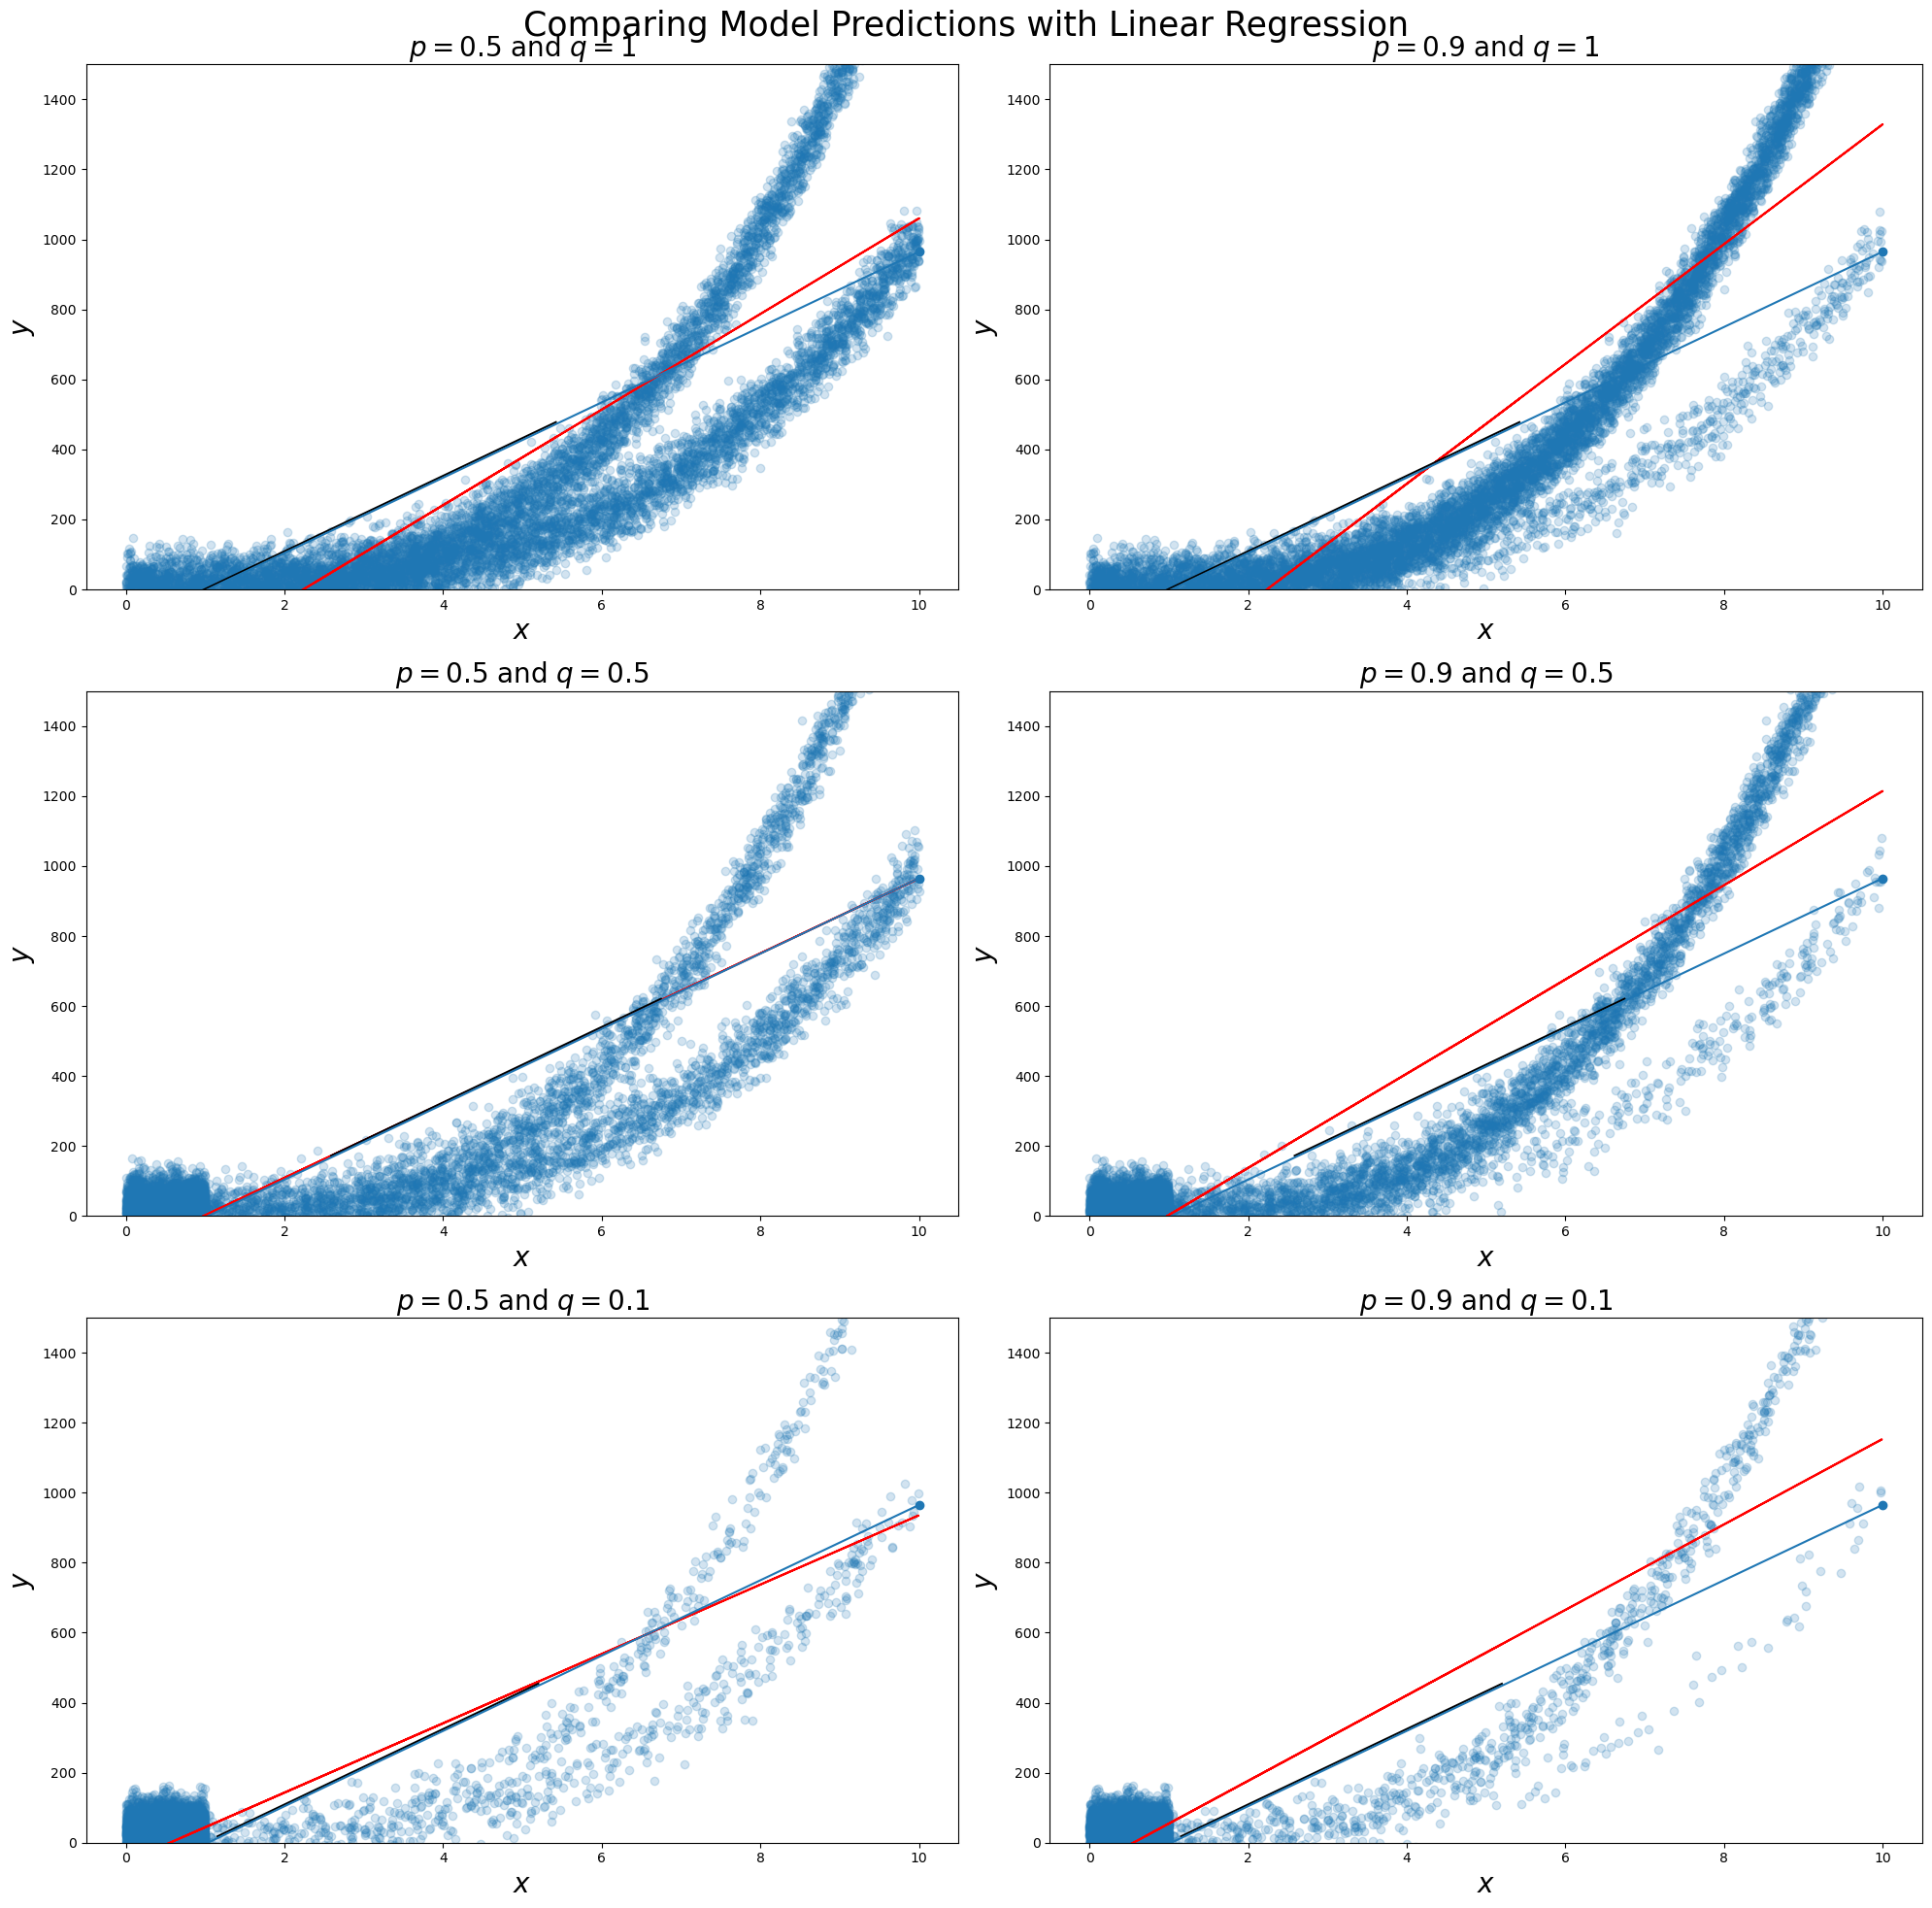

In [60]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
ax = ax.flatten();
for i in range(len(X_unstandardized)):
    ax[i].scatter(X_unstandardized[i], y_unstandardized[i], alpha=0.2)
    ax[i].set_title(r"$p={}$".format(round(p_tests[i % 2], 3)) + " and " + r"$q={}$".format(round(q_tests[int(i / 2)], 3)), fontsize=20)
    ax[i].set_xlabel(r"$x$", fontsize=20)
    ax[i].set_ylabel(r"$y$", fontsize=20)
    ax[i].set_ylim(0, 1500)
    
    lobf = LinearRegression()
    lobf.fit(X_unstandardized[i], y_unstandardized[i])
    print(lobf.coef_)
    y_pred = lobf.predict(X_unstandardized[i])
    ax[i].plot(X_unstandardized[i], y_pred, color='red', label='Linear Regression')
    
    first_two = X_unstandardized[i][:2]
    model = LinearRegression()
    model.fit(first_two, plot_pred[i])
    print(model.coef_)
    model_pred = model.predict(first_two)
    ax[i].plot(first_two, model_pred, color='black', label='Linear Regression')
    
    ax[i].plot([x1, x2], [y1, y2], marker='o', label='Points')
plt.suptitle("Comparing Model Predictions with Linear Regression", fontsize=25)
plt.savefig("modelpred_vs_linearreg.png")
plt.tight_layout()